# TP 2 – Análisis de Datos
**Autor:** Rodrigues da Cruz, Nicolás  

### Descripcion de la base

El SNEEP es la estadística penitenciaria oficial de la argentina y muestra la evolución y las características de la población privada de libertad en unidades penitenciarias. Este dataset cuenta con la información correspondiente al año 2023.

### Planteo del problema

El problema de ML elegido es un modelo de clasificación que permita predecir si una persona privada de libertad obtiene una salida transitoria.

En Argentina, las salidas transitorias son fundamentales para la reinserción de la población penitenciaria en la sociedad. Con este modelo buscamos identificar los factores demográficos, procesales y penitenciarios asociados a su concesión, a fin de orientar y optimizar las políticas de reinserción.

Pensando en sentar las bases para resolver este problema (entrenar un modelo que prediga si una persona tendra o no salidas transitorias) se realizara un preprocesamiento, limpieza, manejo de nulos/outliers, split evitando realizar leakage, escalado/normalización, featureengineering y conversión de variables, balanceo de clases y reducción de dimensionalidad.  


## 0. Carga de datos e importancion de librerias

In [1]:
import numpy as np
import pandas as pd
import re
import inspect 
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    OneHotEncoder,
    KBinsDiscretizer,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE, RandomOverSampler
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 140)


In [2]:
df = pd.read_csv("C:/Users/n.rodrigues.da.cruz/Downloads/sneep-2023.csv") 

print("Shape:", df.shape)
display(df.head(3))

Shape: (111967, 86)


,censo_anio,provincia_sneep_id,provincia_descripcion,establecimiento_id,establecimiento_descripcion,edad,genero_id,genero_descripcion,nacionalidad_id,nacionalidad_descripcion,estado_civil_id,estado_civil_descripcion,nivel_instruccion_id,nivel_instruccion_descripcion,ultima_situacion_laboral_id,ultima_situacion_laboral_descripcion,capacitacion_laboral_al_ingresar_id,capacitacion_laboral_al_ingresar_descripcion,ultimo_lugar_residencia_id,ultimo_lugar_residencia_descripcion,ultima_provincia_residencia_sneep_id,ultima_provincia_residencia_descripcion,jurisdiccion_id,jurisdiccion_descripcion,situacion_legal_id,situacion_legal_descripcion,fecha_detencion,fecha_condenado,establecimiento_procedencia_id,establecimiento_procedencia_descripcion,delito1_id,delito1_descripcion,delito2_id,delito2_descripcion,delito3_id,delito3_descripcion,delito4_id,delito4_descripcion,delito5_id,delito5_descripcion,horas_trabajo_remunerado_id,horas_trabajo_remunerado_descripcion,participacion_programa_laboral,participacion_programa_educativo_id,participacion_programa_educativo_descripcion,participacion_actividades_deportivas,recibio_atencion_medica_ult_anio,recibio_atencion_medica_ult_anio_descripcion,recibio_visitas_ultimo_anio,participo_alteracion_orden_ult_anio_id,participo_alteracion_orden_ult_anio_descripcion,tipo_infraccion_disciplinaria_id,tipo_infraccion_disciplinaria_descripcion,sancion_aplicada_id,sancion_aplicada_descripcion,calificacion_conducta_id,calificacion_conducta_descripcion,tentativa_fugas_evasiones_id,tentativa_fugas_evasiones_descripcion,tentativa_suicidio,fue_lesionado_id,fue_lesionado_descripcion,duracion_condena_anios,duracion_condena_meses,duracion_condena_rango,tipo_condena,es_reincidente_id,es_reincidente_descripcion,tiene_periodo_progresividad_id,tiene_periodo_progresividad_descripcion,reparticion_id,reparticion_descripcion,tuvo_salidas_transitorias_id,tuvo_salidas_transitorias_descripcion,incorporado_reg_semi_libertad_id,incorporado_reg_semi_libertad_descripcion,participa_programa_pre_libertad,participa_programa_prision_discontinua_id,participa_programa_prision_discontinua_descripcion,participa_programa_semi_detencion_id,participa_programa_semi_detencion_descripcion,tuvo_reduccion_pena_id,tuvo_reduccion_pena_descripcion,mujer_tiene_hijos_intramuro,provincia_id,ultima_provincia_residencia_id
0,2023,23,Tucumán,163,UNIDAD Nº 3 - ENCAUSADOS CONCEPCIÓN,57,1,Varón,1,Argentina,2,Casado/a,6,Terciario incompleto,3,Desocupado/a,3,No tiene ni oficio ni profesión,2,Urbano,23,Tucumán,25,FEDERAL,1,Condenado/a,30/11/2018 00:00:00,06/11/2020 00:00:00,3,Deriv. de una instit. Policial,11,Privación ilegítima de la libertad,0,NaN,0,NaN,0,NaN,0,NaN,5,No tiene trabajo remunerado,0.0,6,No participa de ningún programa educativo,0.0,2,No,0.0,5,No participó de ninguna alteración,4,No cometió Infracción disciplinaria,0,NaN,7,Sin calificación,3,No,0,4,No fue lesionado,8,0,3,0.0,1,Primario/a,6,No se aplica ninguna,1.0,Provincial,1,No le fueron otorgadas,1,No está incorporado/a al régimen de semilibertad,0.0,1,No está incorporado/a,1,No tiene semidetención,4,No tuvo reducción de pena,NaN,90,90.0
1,2023,23,Tucumán,163,UNIDAD Nº 3 - ENCAUSADOS CONCEPCIÓN,34,1,Varón,1,Argentina,1,Soltero/a,2,Primario incompleto,2,Trabajador/ra de tiempo parcial,3,No tiene ni oficio ni profesión,2,Urbano,23,Tucumán,23,PROVINCIAL - Tucumán,1,Condenado/a,10/11/2011 00:00:00,24/07/2015 00:00:00,3,Deriv. de una instit. Policial,1,Homicidios dolosos,0,NaN,0,NaN,0,NaN,0,NaN,5,No tiene trabajo remunerado,0.0,6,No participa de ningún programa educativo,0.0,1,Si - Recibió Asistencia Médica,1.0,5,No participó de ninguna alteración,4,No cometió Infracción disciplinaria,0,NaN,1,Ejemplar,3,No,0,4,No fue lesionado,0,0,8,1.0,1,Primario/a,6,No se aplica ninguna,1.0,Provincial,1,No le fueron otorgadas,1,No está incorporado/a al régimen de semilibertad,0.0,1,No está incorporado/a,1,No tiene semidetención,4,No tuvo reducción de pena,NaN,90,90.0
2,2023,1,Buenos Aires,162,UNIDAD 30 - GENERAL ALVEA

## 1. Variable Target

Se toma como variable objetivo tuvo_salidas_transitorias_descripcion, y se la transforma de forma tal que:
1 = “Sí – goza de salidas transitorias”
0 = resto (incluye nulos). Se dropea luego la columna tuvo_salidas_transitorias_descripcion ya que es sumamente dependiente del target

In [3]:
df['target'] = (
    df['tuvo_salidas_transitorias_descripcion']
      .astype(str)
      .str.contains("Si - goza de salidas transitorias", case=False, na=False)
).astype(int)

df.drop(columns=['tuvo_salidas_transitorias_descripcion'], inplace=True)

## 2. Preporcesamiento y limpieza del dataset

### 2.1 Eliminación de datos inconsistentes o irrelevantes.

En el anterior TP se pudo observar que la columna situacion_legal_descripcion afecta directamente el contenido de diversas variables. Siendo así, el valor “Condenado/a” en situacion_legal_descripcion está asociado a tipo_condena, es_reincidente_descripcion, tiene_periodo_progresividad_descripcion, tuvo_salidas_transitorias_descripcion, incorporado_reg_semi_libertad_descripcion, participa_programa_pre_libertad, participa_programa_prision_discontinua_descripcion y participa_programa_semi_detencion_descripcion; todas estas columnas presentan valores nulos cuando situacion_legal_descripcion difiere de “Condenado/a”.

Teniendo la variable tuvo_salidas_transitorias_descripcion como objetivo, el análisis solo se aplica a registros de personas condenadas, ya que la salida transitoria únicamente puede otorgarse a quien ha sido efectivamente condenado.

In [4]:
#Se filtra el DataFrame para incluir solo los casos de "Condenado/a"
df = df[df['situacion_legal_descripcion'] == 'Condenado/a']

En el dataset existen 36 columnas id, si bien se podría pensar que algunas de ellas sirven como encoding de las variables categoricas a las cuales corresponden esto no es asi en varios casos (ej. establecimiento_procedencia_descripcion)

In [5]:
#La variable cuenta con los siguientes valores mientras que su correspondiente de id cuenta con valores del 1 al 4 (siendo este orden no necesariamente uno que traduzca correctamente la realidad)
df['establecimiento_procedencia_descripcion'].unique()

array(['Deriv. de una instit. Policial', 'Deriv. de otro establecimiento',
       'Ingreso directo',
       'Deriv. de una instit. depend de una fuerza de seg.', nan],
      dtype=object)

Por este motivo se procede a dropear las columnas id del dataset dejando las transformaciones (si las hubiera) de las variables categoricas para el feature engineering

In [6]:
def tiene_id(col):
    tokens = re.split(r'[^a-zA-Z0-9]+', col.lower())
    return "id" in tokens

id_cols = [c for c in df.columns if tiene_id(c)]

df = df.drop(columns=id_cols, errors="ignore")

print("Columnas removidas (ID):", len(id_cols))
print("Nueva forma de df:", df.shape)

Columnas removidas (ID): 36
Nueva forma de df: (67352, 50)


La base de datos cuenta con un solo año por lo que se procede a dropear la columna censo_anio. Por otro lado, la columna recibio_atencion_medica_ult_anio tambien representa un id por lo que tambien se la elimina de la base

In [7]:
df.drop(columns=['censo_anio', 'recibio_atencion_medica_ult_anio', 'situacion_legal_descripcion'], inplace=True)

### 2.2 Split del dataset

Con el fin de evitar que suceda un data leakage a la hora de tratar nulos, outliers y realizar operación de *feature engineering* es fundamental realizar un split del dataset en *train* y *test*.

In [8]:
y = df[["target"]]
X = df.drop(columns=["target"])

Se utiliza stratify para mantener la misma proporcion de clases tanto en el conjunto de entrenamiento como en el de testeo

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)
display(y_train.value_counts(normalize=True).round(4).rename("ratio_train").to_frame())
display(y_test.value_counts(normalize=True).round(4).rename("ratio_test").to_frame())

Train: (53881, 46) Test: (13471, 46)


,ratio_train
target,
0,0.9407
1,0.0593


,ratio_test
target,
0,0.9407
1,0.0593


### 2.3 Analisis y tratamiento de los nulos

En esta sección se procede a realizar un análisis y un tratamiento de los datos faltantes.

In [10]:
df_info = pd.DataFrame({
    'dtype': X_train.dtypes.astype(str),
    '%missing': X_train.isna().mean().round(4),
    'nunique': X_train.nunique()
}).sort_values('%missing', ascending=False)
display(df_info)

,dtype,%missing,nunique
delito5_descripcion,object,0.9937,21
delito4_descripcion,object,0.9791,25
mujer_tiene_hijos_intramuro,float64,0.9664,2
delito3_descripcion,object,0.9316,27
sancion_aplicada_descripcion,object,0.8317,9
delito2_descripcion,object,0.7620,30
fecha_condenado,object,0.1107,4580
es_reincidente_descripcion,object,0.0650,3
nivel_instruccion_descripcion,object,0.0555,9
tuvo_reduccion_pena_descripcion,object,0.0547,4


Se decidió utilizar la moda en el tratamiento de variables con faltantes porque, en este dataset, los NA aparecen únicamente en binarias y categóricas (no hay continuas con NA en esta etapa). Métodos como KNN o MICE están pensados principalmente para variables continuas; aplicarlos acá exige codificar etiquetas, interpolar valores “intermedios” y luego re-binarizar/revertir, lo que introduce supuestos extra y puede distorsionar la proporción de clases. La moda mantiene la distribución original, es simple y estable y evita sobreajuste por imputaciones complejas.

A partir de df_info se identificaron como binarias las columnas con nunique = 2. Sobre estas variables se realizó imputación por la moda estimada en el conjunto de entrenamiento y se aplicó el mismo valor al conjunto de prueba para evitar data leakage y se las paso a enteros (0/1). 

In [11]:

bin_cols = df_info.loc[df_info['nunique'] == 2].index.tolist()

# imputación por MODA aprendida en TRAIN y tipado a enteros 0/1
impute_map = {}
for c in bin_cols:
    X_train[c] = pd.to_numeric(X_train[c], errors="coerce")
    X_test[c]  = pd.to_numeric(X_test[c],  errors="coerce")

    moda = X_train[c].mode(dropna=True)
    impute_map[c] = int(moda.iloc[0]) if not moda.empty else 0  

for c in bin_cols:
    X_train[c] = X_train[c].fillna(impute_map[c]).astype("int8")
    X_test[c]  = X_test[c].fillna(impute_map[c]).astype("int8")

print(f"Columnas imputadas: {bin_cols}")


Columnas imputadas: ['mujer_tiene_hijos_intramuro', 'participacion_programa_laboral', 'participa_programa_pre_libertad', 'tipo_condena', 'participacion_actividades_deportivas', 'recibio_visitas_ultimo_anio', 'reparticion_descripcion', 'ultimo_lugar_residencia_descripcion']


Todas las variables de la forma delitoN_descripcion (N = 1, 2, 3, …) presentan ausencias asociadas a que no existe un N-ésimo delito para un determinado registro. Para explicitar este caso y evitar la pérdida de observaciones, se imputaron los valores faltantes con el rótulo “No se especifica” en train y test, manteniendo una codificación categórica coherente para el featureengineering (p. ej., One-Hot Encoding). 

In [12]:
delito_cols = [
    "delito1_descripcion",
    "delito2_descripcion",
    "delito3_descripcion",
    "delito4_descripcion",
    "delito5_descripcion",
    "sancion_aplicada_descripcion"
]
delito_cols = [c for c in delito_cols if c in X_train.columns]

for df_ in (X_train, X_test):
    for c in delito_cols:
        df_[c] = df_[c].fillna("No se especifica")

print(f"Columnas imputadas: {delito_cols}")

Columnas imputadas: ['delito1_descripcion', 'delito2_descripcion', 'delito3_descripcion', 'delito4_descripcion', 'delito5_descripcion', 'sancion_aplicada_descripcion']


Estas imputaciones preservan el significado de ‘no informado/ajeno a la categoría’ y evitan forzar promedios sobre etiquetas.

Sobre las columnas de tipo categórico (object/category) que conservaban valores faltantes tras los tratamientos anteriores, se aplicó una imputación por moda estimada exclusivamente en el conjunto de entrenamiento y replicada en el conjunto de prueba, a fin de evitar data leakage. 

In [13]:
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
cat_missing = [c for c in cat_cols if X_train[c].isna().any()]

#imputación por MODA aprendida en TRAIN y aplicación en TEST
impute_map_mode = {}
for c in cat_missing:
    moda = X_train[c].mode(dropna=True)
    impute_map_mode[c] = (moda.iloc[0] if not moda.empty else "MISSING")

for c in cat_missing:
    X_train[c] = X_train[c].fillna(impute_map_mode[c])
    X_test[c]  = X_test[c].fillna(impute_map_mode[c])

print("Columnas categóricas imputadas por moda:", list(impute_map_mode.keys()))

Columnas categóricas imputadas por moda: ['establecimiento_descripcion', 'nacionalidad_descripcion', 'estado_civil_descripcion', 'nivel_instruccion_descripcion', 'ultima_situacion_laboral_descripcion', 'capacitacion_laboral_al_ingresar_descripcion', 'ultima_provincia_residencia_descripcion', 'jurisdiccion_descripcion', 'fecha_detencion', 'fecha_condenado', 'establecimiento_procedencia_descripcion', 'horas_trabajo_remunerado_descripcion', 'participacion_programa_educativo_descripcion', 'recibio_atencion_medica_ult_anio_descripcion', 'participo_alteracion_orden_ult_anio_descripcion', 'tipo_infraccion_disciplinaria_descripcion', 'calificacion_conducta_descripcion', 'tentativa_fugas_evasiones_descripcion', 'fue_lesionado_descripcion', 'es_reincidente_descripcion', 'tiene_periodo_progresividad_descripcion', 'incorporado_reg_semi_libertad_descripcion', 'participa_programa_prision_discontinua_descripcion', 'participa_programa_semi_detencion_descripcion', 'tuvo_reduccion_pena_descripcion']


### 2.4 Analisis y tratamiento de outliers

En esta sección se realizará un análisis de outliers para el dataset de estadisticas penitenciarias. 

Excluidas del análisis (binarias/constantes): ['ultimo_lugar_residencia_descripcion', 'participacion_programa_laboral', 'participacion_actividades_deportivas', 'recibio_visitas_ultimo_anio', 'tipo_condena', 'reparticion_descripcion', 'participa_programa_pre_libertad', 'mujer_tiene_hijos_intramuro']
Numéricas a analizar: ['edad', 'tentativa_suicidio', 'duracion_condena_anios', 'duracion_condena_meses', 'duracion_condena_rango'] ... (5 cols)


,col,q1,q3,iqr,lo,hi,outlier_rate_train,skew_train,%missing_train,non_negative
0,duracion_condena_rango,2.0,4.0,2.0,-1.0,7.0,0.040905,1.022971,0.0,True
1,duracion_condena_anios,3.0,10.0,7.0,-7.5,20.5,0.025872,1.634830,0.0,True
2,edad,27.0,43.0,16.0,3.0,67.0,0.021826,0.717372,0.0,True
3,tentativa_suicidio,0.0,0.0,0.0,0.0,0.0,0.006366,13.312655,0.0,True
4,duracion_condena_meses,0.0,6.0,6.0,-9.0,15.0,0.002747,2.163316,0.0,True


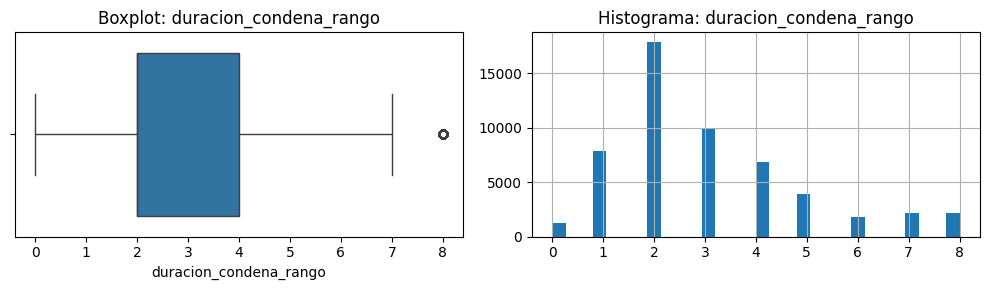

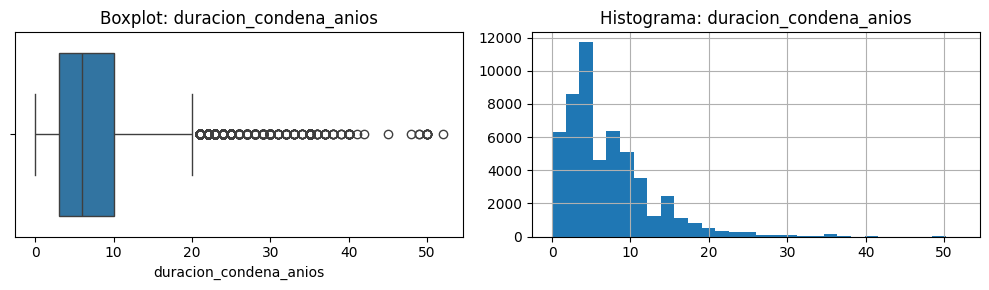

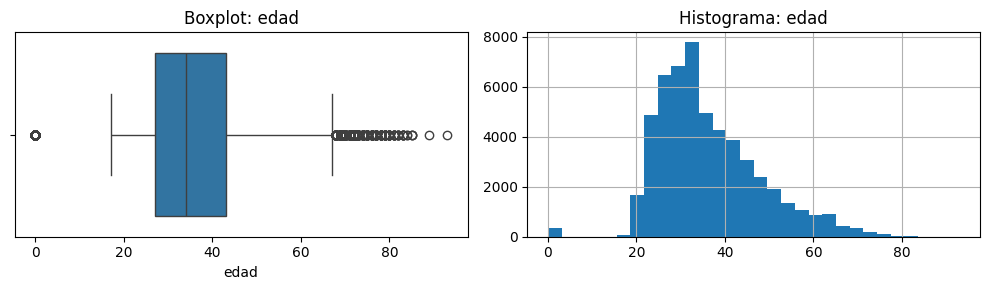

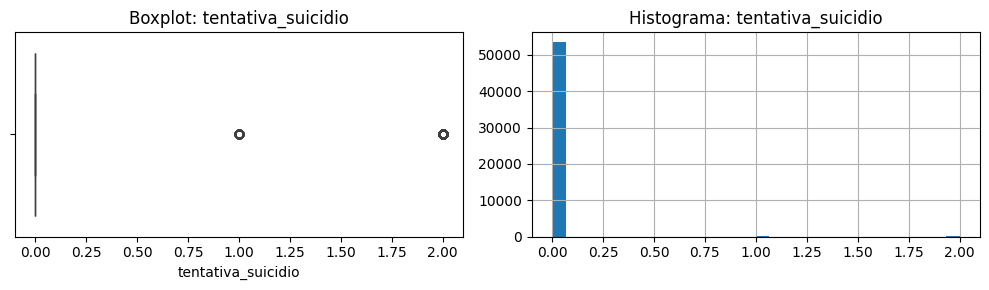

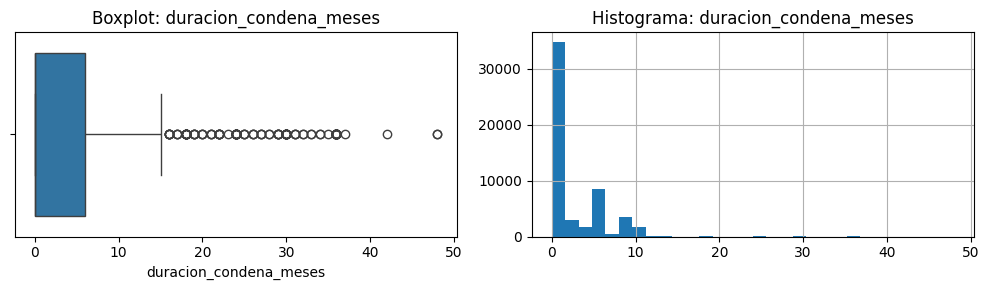

In [14]:
import seaborn as sns

# se toman las variables numéricas
num_all = X_train.select_dtypes(include=[np.number]).columns.tolist()

# excluir binarias/constantes (nunique <= 2 en TRAIN)
exclude_bin_const = [c for c in num_all if X_train[c].dropna().nunique() <= 2]
num_cols = [c for c in num_all if c not in exclude_bin_const]

print("Excluidas del análisis (binarias/constantes):", exclude_bin_const)
print("Numéricas a analizar:", num_cols[:15], "...", f"({len(num_cols)} cols)")

def iqr_bounds(s, k=1.5):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty: 
        return (np.nan,)*5
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo  = q1 - k*iqr
    hi  = q3 + k*iqr
    return q1, q3, iqr, lo, hi

diag_rows = []
for c in num_cols:
    s = pd.to_numeric(X_train[c], errors="coerce")
    q1, q3, iqr, lo, hi = iqr_bounds(s, 1.5)
    if pd.isna(lo):
        continue
    rate = ((s < lo) | (s > hi)).mean()
    diag_rows.append({
        "col": c, "q1": q1, "q3": q3, "iqr": iqr,
        "lo": lo, "hi": hi,
        "outlier_rate_train": float(rate),
        "skew_train": float(s.skew(skipna=True)),
        "%missing_train": float(s.isna().mean()),
        "non_negative": bool((s.dropna() >= 0).all())
    })

out_diag = pd.DataFrame(diag_rows).sort_values("outlier_rate_train", ascending=False).reset_index(drop=True)
display(out_diag.head(20))


topk = out_diag["col"].tolist()
for c in topk:
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    sns.boxplot(x=pd.to_numeric(X_train[c], errors="coerce"), ax=ax[0])
    ax[0].set_title(f"Boxplot: {c}")
    pd.to_numeric(X_train[c], errors="coerce").dropna().hist(bins=30, ax=ax[1])
    ax[1].set_title(f"Histograma: {c}")
    plt.tight_layout()
    plt.show()


En edad se consideró inválido estar fuera del rango 14–100 años. Esos casos se marcaron como faltantes y se reemplazaron por la mediana calculada en el conjunto de entrenamiento, aplicando el mismo valor al conjunto de prueba. Con esto se corrigen registros imposibles (como edad = 0) sin cambiar el resto que si bien pueden ser outliers son tecnicamente posibles. En ninguno de los casos se usaron los límites del boxplot (IQR) para imputar valores atipicos ya que se consideran que son raros pero tecnicamente posibles.

In [15]:
EDAD_MIN = 14
EDAD_MAX = 100

invalid_tr = ((X_train["edad"] < EDAD_MIN) | (X_train["edad"] > EDAD_MAX))
invalid_te = ((X_test["edad"]  < EDAD_MIN) | (X_test["edad"]  > EDAD_MAX))

X_train.loc[invalid_tr, "edad"] = np.nan
X_test.loc[invalid_te,  "edad"] = np.nan

# Imputar con la MEDIANA calculada solo en TRAIN
edad_mediana = X_train["edad"].median(skipna=True)
X_train["edad"] = X_train["edad"].fillna(edad_mediana) 
X_test["edad"]  = X_test["edad"].fillna(edad_mediana)

Se revisó cuántas categorías tiene cada variable y qué porcentaje ocupan las categorías muy poco frecuentes (menos de 1% en train). Para las columnas con muchos niveles se agruparon esas categorías raras bajo la etiqueta “OTROS”, usando siempre el criterio aprendido en entrenamiento y aplicándolo igual en test. Así se evita crear demasiadas dummies con poquísima información. En el cuadro se ve cuánto se redujo la cantidad de niveles y cuáles son las categorías más comunes después del ajuste.

In [16]:
#columnas de fecha a EXCLUIR
date_cols = ["fecha_condenado", "fecha_detencion"]
date_cols = [c for c in date_cols if c in X_train.columns]

# columnas categóricas (object/category/bool)
cat_cols_all = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
cat_cols = [c for c in cat_cols_all if c not in date_cols]

RARE_FREQ = 0.01   # <1% en train se considera "raro"
HIGH_CARD = 30     # aplicar solo en columnas con >30 niveles

# iagnóstico "antes" (TRAIN)
diag_rows = []
for c in cat_cols:
    vc = X_train[c].value_counts(normalize=True, dropna=False)
    rare = vc[vc < RARE_FREQ]
    diag_rows.append({
        "col": c,
        "nlevels_train": int(vc.shape[0]),
        "%rare_mass_train": float(rare.sum()),
        "n_rare_levels_train": int(rare.shape[0]),
    })

cat_diag_before = pd.DataFrame(diag_rows).sort_values(["nlevels_train","%rare_mass_train"], ascending=False)
display(cat_diag_before.head(20))

# columnas de alta cardinalidad donde se agrupará en "OTROS"
high_card_cols = cat_diag_before.loc[cat_diag_before["nlevels_train"] > HIGH_CARD, "col"].tolist()
print("Columnas de alta cardinalidad (train):", high_card_cols)

keep_levels_map = {}
for c in high_card_cols:
    vc = X_train[c].astype(str).value_counts(normalize=True, dropna=False)
    keep = set(vc[vc >= RARE_FREQ].index.astype(str))
    if "MISSING" in vc.index: 
        keep.add("MISSING")
    keep_levels_map[c] = keep

for df_ in (X_train, X_test):
    for c in high_card_cols:
        s = df_[c].astype(str)
        df_[c] = s.where(s.isin(keep_levels_map[c]), "OTROS")

after_rows = []
for c in high_card_cols:
    after_rows.append({
        "col": c,
        "nlevels_train_despues": int(X_train[c].nunique(dropna=False)),
        "top5_train": X_train[c].value_counts(dropna=False).head(5).to_dict()
    })
resumen_cats = pd.DataFrame(after_rows).sort_values("nlevels_train_despues", ascending=False)
display(resumen_cats)


,col,nlevels_train,%rare_mass_train,n_rare_levels_train
1,establecimiento_descripcion,309,0.542770,281
12,delito2_descripcion,31,0.062601,22
11,delito1_descripcion,31,0.055697,19
13,delito3_descripcion,28,0.057905,26
9,jurisdiccion_descripcion,26,0.052022,10
14,delito4_descripcion,26,0.020861,25
8,ultima_provincia_residencia_descripcion,24,0.049591,8
0,provincia_descripcion,24,0.038474,7
15,delito5_descripcion,22,0.006255,21
3,nacionalidad_descripcion,15,0.021492,12


Columnas de alta cardinalidad (train): ['establecimiento_descripcion', 'delito2_descripcion', 'delito1_descripcion']


,col,nlevels_train_despues,top5_train
0,establecimiento_descripcion,29,"{'OTROS': 29245, 'COMPLEJO PENITENCIARIO Nº II..."
2,delito1_descripcion,13,"{'Robo y/o tentativa de robo': 16836, 'Violaci..."
1,delito2_descripcion,10,"{'No se especifica': 41058, 'OTROS': 3373, 'Ro..."


Se capearon outliers donde tienen interpretación cuestionable (p. ej., edad=0) y se aplicó IQR en duracion_condena_meses. No se modificaron otras variables porque se consideran valores plausibles del fenómeno.

### 2.5 Normalización y escalado de features

En esta etapa se escalaron únicamente las variables numéricas dejando afuera las binarias/constantes. Para la mayoría se usó StandardScaler y, cuando la distribución presentaba asimetría positiva, RobustScaler, que es más estable con valores extremos. Todo se ajustó con el conjunto de entrenamiento y se aplicó igual en test, manteniendo el mismo criterio en ambos. 

In [17]:

# columnas numéricas
num_all = X_train.select_dtypes(include=[np.number]).columns.tolist()

# excluir binarios/constantes
exclude_bin_const = [c for c in num_all if X_train[c].dropna().nunique() <= 2]

num_scale = [c for c in num_all if c not in set(exclude_bin_const)]

# separar por asimetría: Robust para muy sesgadas, Standard para el resto
SKEW_THRESH = 1.0 
skews = X_train[num_scale].skew(numeric_only=True)

robust_cols   = [c for c in num_scale if skews.get(c, 0) > SKEW_THRESH]
standard_cols = [c for c in num_scale if c not in robust_cols]

# aplicar escalado (fit en train -> transform en test)
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

std_scaler = StandardScaler()
X_train_scaled[standard_cols] = std_scaler.fit_transform(X_train[standard_cols])
X_test_scaled[standard_cols]  = std_scaler.transform(X_test[standard_cols])

rob_scaler = RobustScaler()
X_train_scaled[robust_cols] = rob_scaler.fit_transform(X_train[robust_cols])
X_test_scaled[robust_cols]  = rob_scaler.transform(X_test[robust_cols])

print("No escaladas (bin/const):", exclude_bin_const)
print("StandardScaler:", standard_cols)
print("RobustScaler:", robust_cols)
print("Shapes:", X_train_scaled.shape, X_test_scaled.shape)

No escaladas (bin/const): ['ultimo_lugar_residencia_descripcion', 'participacion_programa_laboral', 'participacion_actividades_deportivas', 'recibio_visitas_ultimo_anio', 'tipo_condena', 'reparticion_descripcion', 'participa_programa_pre_libertad', 'mujer_tiene_hijos_intramuro']
StandardScaler: ['edad']
RobustScaler: ['tentativa_suicidio', 'duracion_condena_anios', 'duracion_condena_meses', 'duracion_condena_rango']
Shapes: (53881, 46) (13471, 46)


## 3. Feature engineering

El objetivo de esta sección es preparar variables que representen mejor el fenómeno y simplifiquen el modelado, manteniendo trazabilidad de cada transformación.

### 3.1 Creacion de nuevas features

In [18]:
# Features de tiempo
for df_ in (X_train, X_test):
    df_["fecha_condenado"] = pd.to_datetime(df_["fecha_condenado"], dayfirst=True, errors="coerce")
    df_["fecha_detencion"] = pd.to_datetime(df_["fecha_detencion"], dayfirst=True, errors="coerce")
    
    # componentes
    df_["anio_condena"] = df_["fecha_condenado"].dt.year
    df_["mes_condena"]  = df_["fecha_condenado"].dt.month
    df_["anio_detencion"] = df_["fecha_detencion"].dt.year
    df_["mes_detencion"]  = df_["fecha_detencion"].dt.month

    # diferencias de días
    df_["dias_detencion_a_condena"] = (df_["fecha_condenado"] - df_["fecha_detencion"]).dt.days

    # cycle encoding de las variables de mes
    df_["mes_condena_sin"] = np.sin(2*np.pi*(df_["mes_condena"]-1)/12)
    df_["mes_condena_cos"] = np.cos(2*np.pi*(df_["mes_condena"]-1)/12)
    df_["mes_detencion_sin"] = np.sin(2*np.pi*(df_["mes_detencion"]-1)/12)
    df_["mes_detencion_cos"] = np.cos(2*np.pi*(df_["mes_detencion"]-1)/12)

    df_.drop(
        columns=[
            "fecha_condenado", "fecha_detencion",  # fechas crudas
            "mes_condena", "mes_detencion"         # ya representados por sin/cos
        ],
        inplace=True,
        errors="ignore"
    )

In [19]:
# Cantidad de delitos presentes
delito_cols = ["delito1_descripcion","delito2_descripcion","delito3_descripcion",
               "delito4_descripcion","delito5_descripcion"]
for df_ in (X_train, X_test):
    mask_especifica = [(df_[c].astype(str).str.strip().str.lower() != "No se especifica") for c in delito_cols]
    df_["n_delitos"] = np.sum(mask_especifica, axis=0).astype(int)

In [20]:
# ordinal encoding de nivel educativo (0 a 8)
ord_map = {
    "Ninguno": 0,
    "Primario incompleto": 1,
    "Primario completo": 2,
    "Secundario incompleto": 3,
    "Secundario completo": 4,
    "Terciario incompleto": 5,
    "Terciario completo": 6,
    "Universitario incompleto": 7,
    "Universitario completo": 8,
}

X_train["nivel_instruccion_ordinal"] = (
    X_train["nivel_instruccion_descripcion"].map(ord_map).astype("float")
)

X_test["nivel_instruccion_ordinal"] = (
    X_test["nivel_instruccion_descripcion"].map(ord_map).astype("float")
)

X_train.drop(columns=["nivel_instruccion_descripcion"], inplace=True, errors="ignore")
X_test.drop(columns=["nivel_instruccion_descripcion"], inplace=True, errors="ignore")

In [21]:
#Convertir variables de programas, sanciones y comportamiento a binarias

for df_ in (X_train, X_test):
    
    s = df_["sancion_aplicada_descripcion"]
    df_["tiene_sancion"] = np.where(s == "No se especifica", 0,
                                  np.where(s.notna(), 1, 0)).astype("int8")

    s = df_["tipo_infraccion_disciplinaria_descripcion"]
    df_["tuvo_infraccion"] = np.where(s == "No cometió Infracción disciplinaria", 0,
                                  np.where(s.notna(), 1, 0)).astype("int8")

    s = df_["es_reincidente_descripcion"]
    df_["es_reincidente_bin"] = np.where(s == "Primario/a", 0,
                                  np.where(s.notna(), 1, 0)).astype("int8")

    s = df_["tuvo_reduccion_pena_descripcion"]
    df_["reduccion_pena_bin"] = np.where(s == "No tuvo reducción de pena", 0,
                                  np.where(s.notna(), 1, 0)).astype("int8") 

    s = df_["participa_programa_prision_discontinua_descripcion"]
    df_["prog_prision_discontinua_bin"] = np.where(s == "No está incorporado/a", 0,
                                  np.where(s.notna(), 1, 0)).astype("int8") 

    df_["prog_semi_detencion_bin"] = df_["participa_programa_semi_detencion_descripcion"]\
        .astype(str).str.startswith(("Si", "SI")).astype("int8")

    df_["prog_educativo_bin"] = df_["participacion_programa_educativo_descripcion"]\
        .astype(str).str.startswith(("Si", "SI")).astype("int8")

    df_["alteracion_orden_bin"]  = df_["participo_alteracion_orden_ult_anio_descripcion"]\
        .astype(str).str.startswith(("Si", "SI")).astype("int8")

    df_["prog_pre_libertad_bin"] = df_["participa_programa_pre_libertad"]

    df_["prog_laboral_bin"] = df_["participacion_programa_laboral"]

    df_["semi_libertad_reg_bin"] = df_["incorporado_reg_semi_libertad_descripcion"]\
        .astype(str).str.startswith(("Si", "SI")).astype("int8")

    df_["atencion_medica_bin"] = df_["recibio_atencion_medica_ult_anio_descripcion"]\
        .astype(str).str.startswith(("Si", "SI")).astype("int8")

    df_["fue_lesionado_bin"] = df_["fue_lesionado_descripcion"]\
        .astype(str).str.startswith(("Si", "SI")).astype("int8")

    df_["fugas_evasiones_bin"] = df_["tentativa_fugas_evasiones_descripcion"]\
        .astype(str).str.startswith(("Si", "SI")).astype("int8")

    df_["programas_total"] = (
        df_["prog_prision_discontinua_bin"] + df_["prog_semi_detencion_bin"] +
        df_["prog_educativo_bin"] + df_["prog_pre_libertad_bin"] + df_["prog_laboral_bin"]
    ).astype("int16")

    df_["incidentes_total"] = (
        df_["tuvo_infraccion"] + df_["alteracion_orden_bin"] +
        df_["fue_lesionado_bin"] + df_["fugas_evasiones_bin"]
    ).astype("int16")

    df_["reinc_x_sancion"] = (df_["es_reincidente_bin"] & df_["tiene_sancion"]).astype("int8")


drop_cols = [
    "es_reincidente_descripcion",
    "tuvo_reduccion_pena_descripcion",
    "participa_programa_prision_discontinua_descripcion",
    "participa_programa_semi_detencion_descripcion",
    "participacion_programa_educativo_descripcion",
    "participa_programa_pre_libertad",
    "participacion_programa_laboral",
    "participo_alteracion_orden_ult_anio_descripcion",
    "incorporado_reg_semi_libertad_descripcion",
    "recibio_atencion_medica_ult_anio_descripcion",
    "fue_lesionado_descripcion",
    "tentativa_fugas_evasiones_descripcion",
    "sancion_aplicada_descripcion",
    "tipo_infraccion_disciplinaria_descripcion",
]

for df_ in (X_train, X_test):
    df_.drop(columns=drop_cols, inplace=True, errors="ignore")

In [22]:
# provincia_descripcion y ultima_provincia_residencia_descripcion -> lat/lon

prov_coords = {
    "Buenos Aires": (-36.6, -60.0),
    "Ciudad de Buenos Aires": (-34.6, -58.4), "CABA": (-34.6, -58.4),
    "Catamarca": (-28.5, -65.8),
    "Chaco": (-27.5, -59.0),
    "Chubut": (-43.3, -67.3),
    "Córdoba": (-31.4, -64.2), "Cordoba": (-31.4, -64.2),
    "Corrientes": (-28.8, -58.3),
    "Entre Ríos": (-32.0, -59.2), "Entre Rios": (-32.0, -59.2),
    "Formosa": (-26.2, -58.2),
    "Jujuy": (-23.3, -65.0),
    "La Pampa": (-37.6, -65.0),
    "La Rioja": (-29.4, -67.0),
    "Mendoza": (-32.9, -68.8),
    "Misiones": (-27.4, -55.9),
    "Neuquén": (-38.95, -68.06), "Neuquen": (-38.95, -68.06),
    "Río Negro": (-40.8, -67.5), "Rio Negro": (-40.8, -67.5),
    "Salta": (-24.8, -65.4),
    "San Juan": (-31.5, -68.6),
    "San Luis": (-33.3, -66.4),
    "Santa Cruz": (-49.0, -69.0),
    "Santa Fe": (-31.6, -60.7),
    "Santiago del Estero": (-27.8, -64.3),
    "Tierra del Fuego": (-54.8, -68.3),
    "Tucumán": (-26.8, -65.2), "Tucuman": (-26.8, -65.2),
}

for df_ in (X_train, X_test):
    prov = df_["provincia_descripcion"].map(prov_coords)
    df_["provincia_lat"] = prov.apply(lambda x: x[0] if isinstance(x, tuple) else np.nan).astype("float32")
    df_["provincia_lon"] = prov.apply(lambda x: x[1] if isinstance(x, tuple) else np.nan).astype("float32")

    resi = df_["ultima_provincia_residencia_descripcion"].map(prov_coords)
    df_["residencia_lat"] = resi.apply(lambda x: x[0] if isinstance(x, tuple) else np.nan).astype("float32")
    df_["residencia_lon"] = resi.apply(lambda x: x[1] if isinstance(x, tuple) else np.nan).astype("float32")

# dropear columnas de texto usadas
X_train.drop(columns=["provincia_descripcion","ultima_provincia_residencia_descripcion"], inplace=True, errors="ignore")
X_test.drop(columns=["provincia_descripcion","ultima_provincia_residencia_descripcion"], inplace=True, errors="ignore")


In [23]:
#es argentino u extranjero
for df_ in (X_train, X_test):
    df_["es_argentino"] = (df_["nacionalidad_descripcion"] == "Argentina").astype("int8")
X_train.drop(columns=["nacionalidad_descripcion"], inplace=True, errors="ignore")
X_test.drop(columns=["nacionalidad_descripcion"], inplace=True, errors="ignore")

In [24]:
# ultima_situacion_laboral_descripcion -> binaria trabajaba (1 si trabajaba, 0 si Desocupado/a)
trabajaba_vals = {"Trabajador/ra de tiempo parcial", "Trabajador/ra de tiempo completo"}
for df_ in (X_train, X_test):
    s = df_["ultima_situacion_laboral_descripcion"]
    df_["trabajaba_al_ultimo"] = np.where(s.isin(trabajaba_vals), 1,
                                   np.where(s.eq("Desocupado/a"), 0, 0)).astype("int8")
X_train.drop(columns=["ultima_situacion_laboral_descripcion"], inplace=True, errors="ignore")
X_test.drop(columns=["ultima_situacion_laboral_descripcion"], inplace=True, errors="ignore")

In [25]:
#capacitacion_laboral_al_ingresar_descripcion -> binaria (tiene oficio/profesión)
tiene_oficio_vals = {"Tiene algún oficio", "Tiene alguna profesión"}
for df_ in (X_train, X_test):
    s = df_["capacitacion_laboral_al_ingresar_descripcion"]
    df_["tiene_oficio_o_profesion"] = np.where(s.isin(tiene_oficio_vals), 1, 0).astype("int8")
X_train.drop(columns=["capacitacion_laboral_al_ingresar_descripcion"], inplace=True, errors="ignore")
X_test.drop(columns=["capacitacion_laboral_al_ingresar_descripcion"], inplace=True, errors="ignore")

In [26]:
# tiene_periodo_progresividad_descripcion -> binaria (1 si aplica algún período, 0 si "No se aplica ninguna")
for df_ in (X_train, X_test):
    s = df_["tiene_periodo_progresividad_descripcion"].fillna("No se aplica ninguna")
    df_["tiene_periodo_progresividad"] = (s != "No se aplica ninguna").astype("int8")
X_train.drop(columns=["tiene_periodo_progresividad_descripcion"], inplace=True, errors="ignore")
X_test.drop(columns=["tiene_periodo_progresividad_descripcion"], inplace=True, errors="ignore")

In [27]:
# convertir horas_trabajo_remunerado_descripcion a ordinal
horas_map = {
    "No tiene trabajo remunerado": 0,
    "Hasta 10 hs. Semanales": 1,
    "Hasta 20 hs. Semanales": 2,
    "Hasta 30 hs. Semanales": 3,
    "Hasta 40 hs. Semanales": 4,
}

for df_ in (X_train, X_test):
    df_["horas_trabajo_ordinal"] = (
        df_["horas_trabajo_remunerado_descripcion"]
          .map(horas_map)
          .astype("Int8")  # entero nullable para permitir NA
    )
    # se elimina el texto original
    df_.drop(columns=["horas_trabajo_remunerado_descripcion"], inplace=True)

In [28]:
# convertir valores de delito1 a dummies, marcando 1 si aparece en cualquiera de los 5
def slugify(txt):
    t = re.sub(r"[^\w\s-]", "", str(txt)).strip().lower()
    t = re.sub(r"\s+", "_", t)
    return t[:40]  # acotar un poco los nombres

vocab_delitos = [v for v in X_train["delito1_descripcion"].dropna().unique().tolist() if v != "No se especifica"]

delito_cols = ["delito1_descripcion","delito2_descripcion","delito3_descripcion","delito4_descripcion","delito5_descripcion"]

for df_ in (X_train, X_test):
    block = df_[delito_cols].astype(str)
    for val in vocab_delitos:
        col_name = f"delito_{slugify(val)}"
        df_[col_name] = (block.eq(val).any(axis=1)).astype("int8")

for df_ in (X_train, X_test):
    df_.drop(columns=delito_cols, inplace=True, errors="ignore")

In [29]:
ohe_cols = ["calificacion_conducta_descripcion", "establecimiento_procedencia_descripcion", "genero_descripcion", "estado_civil_descripcion", "jurisdiccion_descripcion"]

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
Xtr_ohe = enc.fit_transform(X_train[ohe_cols])
Xte_ohe = enc.transform(X_test[ohe_cols])

ohe_names = enc.get_feature_names_out(ohe_cols)
Xtr_ohe_df = pd.DataFrame.sparse.from_spmatrix(Xtr_ohe, index=X_train.index, columns=ohe_names)
Xte_ohe_df = pd.DataFrame.sparse.from_spmatrix(Xte_ohe, index=X_test.index,  columns=ohe_names)

# unir y dropear originales
X_train = pd.concat([X_train.drop(columns=ohe_cols), Xtr_ohe_df], axis=1)
X_test  = pd.concat([X_test.drop(columns=ohe_cols),  Xte_ohe_df], axis=1)

In [30]:
#Se elimina la columna 'establecimiento_descripcion' debido a su alta cardinalidad y al ser poco informativas
X_train.drop(columns=["establecimiento_descripcion"], inplace=True, errors="ignore")
X_test.drop(columns=["establecimiento_descripcion"], inplace=True, errors="ignore")

In [32]:
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (53881, 107) Test: (13471, 107)


Se agregaron derivados de fecha y sumatorias de programas/incidentes para capturar intensidad. Se usó cycle encoding para con los meses, ordinalización donde hay orden natural (instrucción, horas de trabajo) y lat-lon para codificar ubicación sin explosionar categorías entre otros procedimientos. La cantidad de features totales despues del feature engineering es de 107.

### 3.2 Análisis de balance de clases

,train_count,train_ratio,test_count,test_ratio
target,,,,
0,50687,0.9407,12672,0.9407
1,3194,0.0593,799,0.0593


Baseline (clase mayoritaria en TRAIN): 0.9407


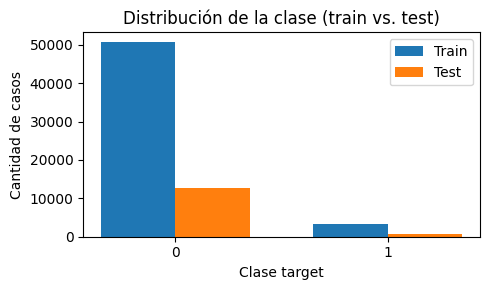

In [33]:
y_train_ser = pd.Series(np.ravel(y_train), name="target")
y_test_ser  = pd.Series(np.ravel(y_test),  name="target")

cnt_tr = y_train_ser.value_counts().sort_index()
rat_tr = y_train_ser.value_counts(normalize=True).sort_index()

cnt_te = y_test_ser.value_counts().sort_index()
rat_te = y_test_ser.value_counts(normalize=True).sort_index()

all_idx = cnt_tr.index.union(cnt_te.index)

# Tabla resumen
balance_tbl = pd.DataFrame({
    "train_count": cnt_tr.reindex(all_idx, fill_value=0),
    "train_ratio": rat_tr.reindex(all_idx, fill_value=0).round(4),
    "test_count":  cnt_te.reindex(all_idx, fill_value=0),
    "test_ratio":  rat_te.reindex(all_idx, fill_value=0).round(4),
})
display(balance_tbl)

baseline_acc = rat_tr.max()
print(f"Baseline (clase mayoritaria en TRAIN): {baseline_acc:.4f}")

labels = [str(v) for v in all_idx]
x = np.arange(len(all_idx))
barw = 0.35

tr_vals = cnt_tr.reindex(all_idx, fill_value=0).values
te_vals = cnt_te.reindex(all_idx, fill_value=0).values

fig, ax = plt.subplots(figsize=(5,3))
ax.bar(x - barw/2, tr_vals, width=barw, label="Train")
ax.bar(x + barw/2, te_vals, width=barw, label="Test")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Clase target")
ax.set_ylabel("Cantidad de casos")
ax.set_title("Distribución de la clase (train vs. test)")
ax.legend()
plt.tight_layout()
plt.show()

- En este problema se tiene una amplia diferencia entre la clase mayoritaria (96,4%) y la minoritaria (3,6%). En este problema particular de ML se debe priorizar la precision ya que es mas costoso otorgar una salida transitoria a una persona a la cual no se le deberia dar.
- Para solucionar el problema del desbalanceo se podria aplicar alguna metodologia de balanceo de clases, como hacer un oversampling (SMOTE, etc.), undersampling.

In [34]:
#Se aplica oversampling utlizando SMOTE para balancear las clases llevando la minoritaria a la misma cantidad que la mayoritaria
ytr = pd.Series(np.ravel(y_train), name="target").astype(int)

num_cols_for_smote = X_train.select_dtypes(include=[np.number]).columns.tolist()
Xtr_num = X_train[num_cols_for_smote].copy()

for c in num_cols_for_smote:
    if pd.api.types.is_sparse(Xtr_num[c].dtype):
        Xtr_num[c] = Xtr_num[c].sparse.to_dense().astype("float32")
Xtr_num = Xtr_num.astype("float32")

minority_count = ytr.value_counts().min()
k_neighbors = min(5, max(1, minority_count - 1))

smote = SMOTE(random_state=42, k_neighbors=k_neighbors) 
X_train_smote, y_train_smote = smote.fit_resample(Xtr_num, ytr)

print("Antes (TRAIN):", ytr.value_counts().to_dict())
print("Después SMOTE:", pd.Series(y_train_smote).value_counts().to_dict())
print("Shape original:", X_train.shape, "| Shape SMOTE:", X_train_smote.shape)

Antes (TRAIN): {0: 50687, 1: 3194}
Después SMOTE: {0: 50687, 1: 50687}
Shape original: (53881, 107) | Shape SMOTE: (101374, 107)


## 4. Reducción de dimensionalidad

### 4.1 Seleccion de features

Primero se inspecciona la correlación de cada variable con el target y la colinealidad entre features. Luego se aplica un filtro de varianza (umbral 0,02) para descartar casi-constantes. Con ese subconjunto se ejecutan pruebas univariadas según el tipo de variable: ANOVA (f_classif) para continuas, chi² para discretas/no negativas, e información mutua para capturar dependencias no lineales. El objetivo es reducir ruido y continuar con la construccion del dataset que alimentara al modelo.

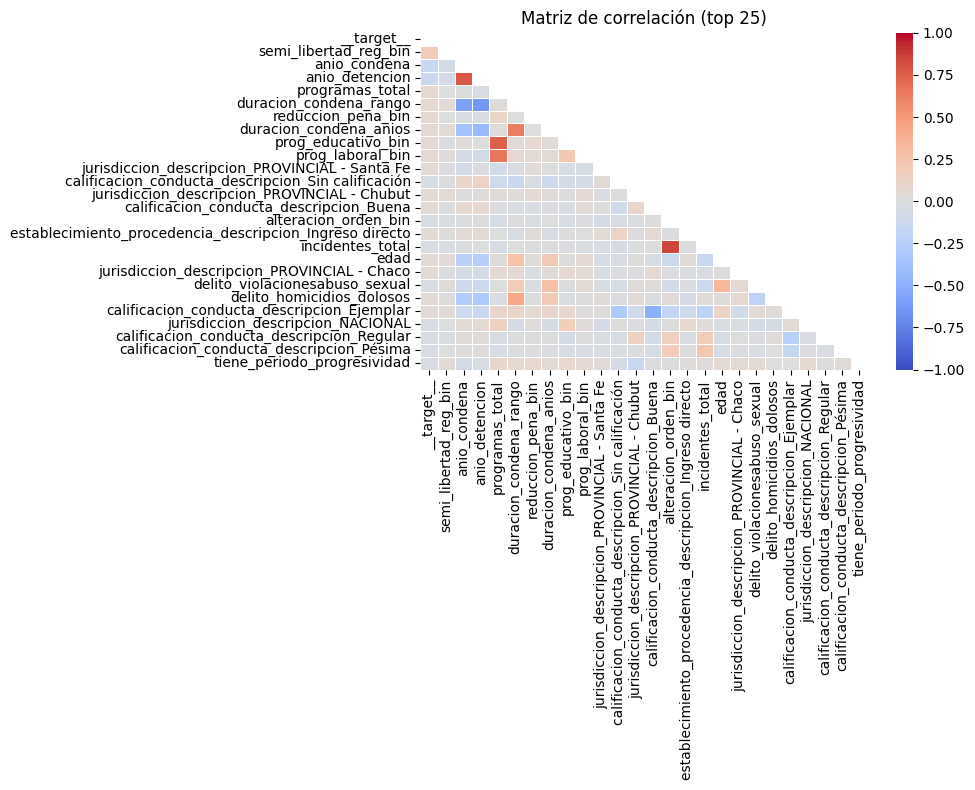

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # si no está instalado,: pip install seaborn

# y como serie 1D alineada
ytr = pd.Series(np.ravel(y_train), index=X_train.index, name="target").astype(int)

# tomar solo numéricas y forzar a denso; imputar medianas para evitar NaN
Xtr_num = X_train.select_dtypes(include=[np.number])
Xtr_num = pd.DataFrame(Xtr_num.to_numpy(), columns=Xtr_num.columns, index=Xtr_num.index)
Xtr_num = Xtr_num.fillna(Xtr_num.median(numeric_only=True))

# correlación con el target (valor absoluto) y top-N
corr_with_y = Xtr_num.corrwith(ytr).abs().sort_values(ascending=False)
TOP_N = 25
top_cols = corr_with_y.head(TOP_N).index.tolist()

# matriz para el mapa: top features + target
M = Xtr_num[top_cols].copy()
M["__target__"] = ytr
order = ["__target__"] + top_cols
C = M[order].corr()

# heatmap (triángulo inferior)
mask = np.triu(np.ones_like(C, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(C, mask=mask, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5, cbar=True)
plt.title(f"Matriz de correlación (top {TOP_N})")
plt.tight_layout()
plt.show()

Se ve que la mayoría de variables tienen correlación débil con el target. Aparecen bloques de colinealidad entre variables de tiempo/duración (duracion_condena_anios, duracion_condena_rango, anio_*) y entre agregados y sus componentes (p. ej., programas_total con prog_educativo_bin/prog_laboral_bin). Se puede ver asi que no hay una feature que explique sola el objetivo y conviene evitar redundancias y seguir con filtros (varianza) y tests univariados (ANOVA/χ²/MI).

In [36]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.02)
vt.fit(Xtr_num.fillna(0.0))

keep_vt_mask = vt.get_support()
keep_vt_cols = Xtr_num.columns[keep_vt_mask].tolist()
drop_vt_cols = [c for c in Xtr_num.columns if c not in keep_vt_cols]

print(f"Conserva {len(keep_vt_cols)} / {Xtr_num.shape[1]} features (var ≥ 0.02).")
print("Ejemplos DROP por baja varianza:", drop_vt_cols[:20])


Conserva 73 / 107 features (var ≥ 0.02).
Ejemplos DROP por baja varianza: ['ultimo_lugar_residencia_descripcion', 'reparticion_descripcion', 'mujer_tiene_hijos_intramuro', 'n_delitos', 'prog_prision_discontinua_bin', 'prog_semi_detencion_bin', 'semi_libertad_reg_bin', 'fugas_evasiones_bin', 'calificacion_conducta_descripcion_Mala', 'calificacion_conducta_descripcion_Pésima', 'establecimiento_procedencia_descripcion_Deriv. de una instit. depend de una fuerza de seg.', 'genero_descripcion_No Binario', 'genero_descripcion_Trans Mujer/Travesti', 'genero_descripcion_Trans Varón', 'estado_civil_descripcion_Separado/a de hecho', 'estado_civil_descripcion_Separado/a o divorciado/a', 'estado_civil_descripcion_Viudo/a', 'jurisdiccion_descripcion_Justicia de la Ciudad de Buenos Aires', 'jurisdiccion_descripcion_PROVINCIAL - Catamarca', 'jurisdiccion_descripcion_PROVINCIAL - Chaco']


Se conservaron 73/107 variables y se descartaron las de varianza < 0,02, es decir, columnas casi constantes en train que aportan muy poca señal al modelo. En los eliminados aparecen sobre todo dummies muy raras (p.ej., categorías de conducta “Mala/Pésima”, géneros poco frecuentes, jurisdicciones/procedencias provinciales con pocos casos) y indicadores con casi todos 0 (p.ej., prog_prision_discontinua_bin, prog_semi_detencion_bin, semi_libertad_reg_bin, fugas_evasiones_bin). También se elimino n_delitos porque en este corte prácticamente no varía (la mayoría de los registros toma el mismo valor).

In [37]:
from sklearn.feature_selection import f_classif

X_f = Xtr_num[keep_vt_cols].copy()
for c in X_f.columns:
    X_f[c] = X_f[c].fillna(X_f[c].median())

F, p = f_classif(X_f.values, ytr.values)
anova_df = (pd.DataFrame({"feature": X_f.columns, "F": F, "pval": p})
            .sort_values("pval")
            .reset_index(drop=True))
display(anova_df.head(10))

sel_anova = anova_df.loc[anova_df["pval"] < 0.05, "feature"].tolist()
print(f"ANOVA seleccionó {len(sel_anova)} features con p < 0.05.")

,feature,F,pval
0,anio_condena,1171.619558,4.837247e-254
1,anio_detencion,1021.719602,4.118486e-222
2,programas_total,309.813648,3.747546e-69
3,duracion_condena_rango,236.516697,2.934887e-53
4,reduccion_pena_bin,233.662793,1.222416e-52
5,duracion_condena_anios,210.855735,1.099960e-47
6,prog_educativo_bin,195.665389,2.205668e-44
7,prog_laboral_bin,191.419062,1.849343e-43
8,jurisdiccion_descripcion_PROVINCIAL - Santa Fe,135.294409,3.102466e-31
9,calificacion_conducta_descripcion_Sin califica...,124.994031,5.494335e-29


ANOVA seleccionó 62 features con p < 0.05.


In [38]:
from sklearn.feature_selection import chi2

X_chi = Xtr_num[keep_vt_cols].copy()
# mantener solo columnas NO NEGATIVAS (chi² lo requiere)
nonneg_cols = [c for c in X_chi.columns if X_chi[c].min(skipna=True) >= 0]
X_chi = X_chi[nonneg_cols].fillna(0.0)

chi_scores, chi_p = chi2(X_chi.values, ytr.values)
chi_df = (pd.DataFrame({"feature": nonneg_cols, "chi2": chi_scores, "pval": chi_p})
          .sort_values("pval")
          .reset_index(drop=True))
display(chi_df.head(10))

sel_chi2 = chi_df.loc[chi_df["pval"] < 0.05, "feature"].tolist()
print(f"Chi² seleccionó {len(sel_chi2)} features con p < 0.05 (no negativas).")


,feature,chi2,pval
0,duracion_condena_anios,945.814513,1.077872e-207
1,edad,319.757936,1.635415e-71
2,duracion_condena_rango,270.849092,7.410616e-61
3,programas_total,224.415206,9.848202e-51
4,reduccion_pena_bin,220.407745,7.369609e-50
5,prog_laboral_bin,154.146554,2.151300e-35
6,incidentes_total,144.474502,2.798010e-33
7,jurisdiccion_descripcion_PROVINCIAL - Santa Fe,124.204971,7.597574e-29
8,calificacion_conducta_descripcion_Sin califica...,118.492521,1.352632e-27
9,calificacion_conducta_descripcion_Buena,101.479200,7.221778e-24


Chi² seleccionó 52 features con p < 0.05 (no negativas).


In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_mi = Xtr_num[keep_vt_cols].copy()
for c in X_mi.columns:
    X_mi[c] = X_mi[c].fillna(X_mi[c].median())

nunique = Xtr_num.nunique(dropna=True)
disc_mask = np.array([nunique[c] <= 12 for c in X_mi.columns])

mi = mutual_info_classif(X_mi.values, ytr.values, discrete_features=disc_mask, random_state=42)
mi_df = (pd.DataFrame({"feature": X_mi.columns, "MI": mi})
         .sort_values("MI", ascending=False)
         .reset_index(drop=True))
display(mi_df.head(10))

# top-k 
K_MI = min(30, max(10, int(0.3 * len(X_mi.columns))))
sel_mi = mi_df.head(K_MI)["feature"].tolist()
print(f"MI: top {K_MI} features.")


,feature,MI
0,anio_condena,0.013240
1,anio_detencion,0.011614
2,provincia_lon,0.009300
3,residencia_lon,0.009280
4,provincia_lat,0.008968
5,residencia_lat,0.008684
6,duracion_condena_anios,0.004467
7,duracion_condena_rango,0.003848
8,dias_detencion_a_condena,0.003819
9,programas_total,0.002825


MI: top 21 features.


ANOVA destaca tiempos/duraciones y programas/beneficios; χ² captura dummies informativas; MI suma dependencias no lineales. La selección final combina estos criterios, siempre dentro del set que pasó varianza.

In [ ]:
selected_features = sorted(
    set(keep_vt_cols) & (set(sel_anova) | set(sel_chi2) | set(sel_mi))
)

X_train_sel = X_train[selected_features].copy()
X_test_sel  = X_test[selected_features].copy()

print(f"Features finales (con var>=0.02 + ANOVA/chi²/MI): {len(selected_features)}")
print("Shapes ->", X_train_sel.shape, X_test_sel.shape)

Features finales (con var>=0.02 + ANOVA/chi²/MI): 62
Shapes -> (53881, 62) (13471, 62)


### 4.2 Extracción de features (PCA/SVD)

En esta sección se implementó extracción de features con dos enfoques: PCA sobre las continuas y TruncatedSVD sobre todo el set numérico que incluye OHE. PCA ayuda a reducir la colinealidad y a concentrar la varianza en pocos componentes, mientras que SVD logra un efecto parecido pero trabaja directo con matrices esparsas. La ventaja en ambos casos es bajar la dimensionalidad y el ruido, aunque se pierde interpretabilidad porque se reemplazan variables originales por combinaciones lineales. 

#### 4.2.1 PCA

In [42]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# cols numéricas
num_cols = X_train_sel.select_dtypes(include=[np.number]).columns
bin_cols  = [c for c in num_cols if X_train_sel[c].dropna().nunique() <= 2]
cont_cols = [c for c in num_cols if c not in bin_cols and not pd.api.types.is_sparse(X_train_sel[c].dtype)]

# matrices (completar NaN)
Xtr_cont = X_train_sel[cont_cols].fillna(0.0).to_numpy()
Xte_cont = X_test_sel[cont_cols].fillna(0.0).to_numpy()

# k mínimo para ≥90% varianza
pca_full = PCA().fit(Xtr_cont)
k90 = int((np.cumsum(pca_full.explained_variance_ratio_) >= 0.90).argmax() + 1)

# PCA final
pca = PCA(n_components=k90, random_state=42)
Ztr = pca.fit_transform(Xtr_cont)
Zte = pca.transform(Xte_cont)

# concatenar BINARIAS
Btr = X_train_sel[bin_cols].fillna(0.0).to_numpy() if len(bin_cols) else np.empty((len(X_train_sel),0))
Bte = X_test_sel[bin_cols].fillna(0.0).to_numpy()  if len(bin_cols) else np.empty((len(X_test_sel),0))

X_train_pca_model = np.hstack([Btr, Ztr])
X_test_pca_model  = np.hstack([Bte, Zte])

print(f"PCA: {len(cont_cols)}→{Ztr.shape[1]} comps (≈{pca.explained_variance_ratio_.sum():.2%}); final dims: {X_train_pca_model.shape[1]}")


PCA: 18→1 comps (≈99.96%); final dims: 45


#### 4.2.2 SVD

In [ ]:
from scipy import sparse
from sklearn.decomposition import TruncatedSVD

def df_to_csr(df: pd.DataFrame) -> sparse.csr_matrix:
    sp = [c for c in df.columns if pd.api.types.is_sparse(df[c].dtype)]
    dn = [c for c in df.columns if c not in sp]
    blocks = []
    if sp: blocks.append(df[sp].sparse.to_coo().tocsr().astype(np.float32))
    if dn: blocks.append(sparse.csr_matrix(df[dn].fillna(0).to_numpy(np.float32)))
    if not blocks: return sparse.csr_matrix((len(df), 0), dtype=np.float32)
    return blocks[0] if len(blocks)==1 else sparse.hstack(blocks, format="csr")

Xtr_num = X_train_sel.select_dtypes(include=[np.number])
Xte_num = X_test_sel.select_dtypes(include=[np.number])

Xtr_csr = df_to_csr(Xtr_num)
Xte_csr = df_to_csr(Xte_num)

k = min(30, Xtr_csr.shape[1]-1)  
svd = TruncatedSVD(n_components=k, random_state=42)
Ztr_svd = svd.fit_transform(Xtr_csr)
Zte_svd = svd.transform(Xte_csr)

X_train_svd_df = pd.DataFrame(Ztr_svd, index=X_train_sel.index, columns=[f"svd_{i+1}" for i in range(k)])
X_test_svd_df  = pd.DataFrame(Zte_svd, index=X_test_sel.index,  columns=[f"svd_{i+1}" for i in range(k)])

print(f"SVD: {Xtr_csr.shape[1]}→{k} comps (cumvar ≈{svd.explained_variance_ratio_.sum():.2%})")

SVD: 62→30 comps (cumvar ≈100.00%)


PCA comprimió las continuas en un único componente que retiene prácticamente toda su varianza. Al unirlo con las binarias, el set quedó en 45 columnas, más compacto y con menos redundancia. Con SVD se redujo el bloque numérico completo de 62 a 30 componentes manteniendo casi toda la varianza, lo que también baja la dimensión y la colinealidad. El costo en ambos casos es la pérdida de interpretabilidad porque se trabaja con combinaciones lineales en lugar de variables originales. En este dataset, el resultado de PCA sugiere que la señal continua es muy redundante, mientras que SVD aparece como una opción válida cuando se quiere comprimir todo el conjunto, incluida la parte one-hot.